<a href="https://colab.research.google.com/github/JayYongjaeKim/MoLab/blob/FirstTon/Regression1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/airbnb-recruiting-new-user-bookings')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/airbnb-recruiting-new-user-bookings'

In [2]:
import pandas as pd

main = pd.read_csv('train.csv.zip')
log = pd.read_csv('sessions.csv.zip')

import datetime
main['date_first_booking'] = pd.to_datetime(main['date_first_booking'])
main['date_account_created'] = pd.to_datetime(main['date_account_created'])
main['timestamp_first_active'] = pd.to_datetime(main['timestamp_first_active'], format='%Y%m%d%H%M%S')
main['timestamp_first_active'] = main['timestamp_first_active'].dt.date

main['is_booked'] = main['date_first_booking'].notnull().astype(int)

main = main[(main['age'] >= 11) & (main['age'] <= 69)]

main = main[(main['gender'] != '-unknown-') & (main['gender'] != 'OTHER')]

main['timedelta'] = (main['date_first_booking'] - pd.to_datetime(main['timestamp_first_active'])).dt.days

main = main.drop(columns=['date_first_booking'])

main['timedelta'] = main['timedelta'].fillna(0)

main = main.drop(columns=['first_affiliate_tracked'], axis=0)

# 행동
log['action'] = log['action'].fillna('unknown')
log['action_detail'] = log['action_detail'].fillna('unknown')
log['action_type'] = log['action_type'].fillna('unknown')

encoded_data = pd.get_dummies(log[['action', 'action_detail', 'action_type']])


# 수많은 행동 행데이터를 열컬럼으로 전환하여 모든 데이터를 학습하는 용도로 사용할수 있도록 저장
action_pivot = log.pivot_table(index='user_id', columns='action', values='secs_elapsed', aggfunc='count').fillna(0)
action_detail_pivot = log.pivot_table(index='user_id', columns='action_detail', values='secs_elapsed', aggfunc='count').fillna(0)
action_type_pivot = log.pivot_table(index='user_id', columns='action_type', values='secs_elapsed', aggfunc='count').fillna(0)

from functools import reduce
pivot_tables = [action_pivot, action_detail_pivot, action_type_pivot]

log_pivot = reduce(lambda left, right: pd.merge(left, right, on='user_id', how='outer'), pivot_tables).fillna(0)
log_pivot.reset_index(inplace=True)

# 우리의 목표는 구매일관련 회귀와 분류로서 당일과 당일이 아닌 구분이중요 ( 이는 EDA 정리본의 0일내 구매자와 그외 구매자 비율에서 확인)
fast_group = main[main['timedelta'] <= 0]['id']
slow_group = main[main['timedelta'] > 0]['id']

# anti_join 이라는 새로운 방식을 사용하여 서로에게 공통의 영향을 미치는 행동을 제외 unique 하게 영향을 미치는 목록 리스트 20개를 선정하는 방식을 사용하여 학습
fast_actions = log[log['user_id'].isin(fast_group)]['action_detail'].value_counts().head(20).index
slow_actions = log[log['user_id'].isin(slow_group)]['action_detail'].value_counts().head(20).index

anti_join_features = list(set(fast_actions) - set(slow_actions)) + list(set(slow_actions) - set(fast_actions))


# 행동별 다르게 나타나는 값에 대해 가중치를 부여하는 방식
log['median_time'] = log.groupby(['action_detail'])['secs_elapsed'].transform('median')

log['weight'] = log['median_time'] / log.groupby('action_detail')['secs_elapsed'].transform('count')
log['score'] = log['secs_elapsed'] * log['weight']

scores = log.groupby('user_id')['score'].sum().reset_index(name='total_score')

# 여기까지가 회귀 및 분류의 공통적인 전처리 과정

In [ ]:
from sklearn.preprocessing import StandardScaler

log_pivot2 = log_pivot.drop(columns=['user_id'], errors='ignore')

scaler = StandardScaler()
log_pivot_scaled = scaler.fit_transform(log_pivot2)

from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca_features = pca.fit_transform(log_pivot_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

for i in range(7):
    log_pivot[f'PC{i+1}'] = pca_features[:, i]

merged_data = pd.merge(main, log_pivot, left_on='id', right_on='user_id', how='left').fillna(0)
merged_data = pd.merge(merged_data, scores, left_on='id', right_on='user_id', how='left').fillna(0)


merged_data['date_account_created'] = pd.to_datetime(merged_data['date_account_created'])
merged_data['timestamp_first_active'] = pd.to_datetime(merged_data['timestamp_first_active'])
merged_data['days_since_creation'] = (merged_data['date_account_created'] - merged_data['date_account_created'].min()).dt.days
merged_data['days_since_first_active'] = (merged_data['timestamp_first_active'] - merged_data['timestamp_first_active'].min()).dt.days

merged_data = merged_data.drop(columns=['date_account_created', 'timestamp_first_active'], errors='ignore')


purchased_data = merged_data[merged_data['is_booked'] == 1].copy()


action_detail_to_user_ids = log.groupby('action_detail')['user_id'].apply(set).to_dict()


In [4]:
for feature in anti_join_features:
    if feature in action_detail_to_user_ids:
        feature_user_ids = action_detail_to_user_ids[feature]
        purchased_data[f'anti_{feature}'] = purchased_data['id'].apply(lambda x: 1 if x in feature_user_ids else 0)
    else:
        purchased_data[f'anti_{feature}'] = 0


feature_columns = [
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
    'total_score', 'days_since_creation', 'days_since_first_active'
] + [f'anti_{feature}' for feature in anti_join_features]

X = purchased_data[feature_columns]
y = purchased_data['timedelta']

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")

Training Linear Regression...
Training Lasso Regression...
Training Ridge Regression...
Training ElasticNet...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Decision Tree...
Training K-Nearest Neighbors...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 38420, number of used features: 12
[LightGBM] [Info] Start training from score 52.812285
Linear Regression:
  Mean Absolute Error (MAE): 67.78
  Root Mean Squared Error (RMSE): 92.15
Lasso Regression:
  Mean Absolute Error (MAE): 67.82
  Root Mean Squared Error (RMSE): 92.16
Ridge Regression:
  Mean Absolute Error (MAE): 67.78
  Root Mean Squared Error (RMSE): 92.15
ElasticNet:
  Mean Absolut

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 38420, number of used features: 12
[LightGBM] [Info] Start training from score 52.812285


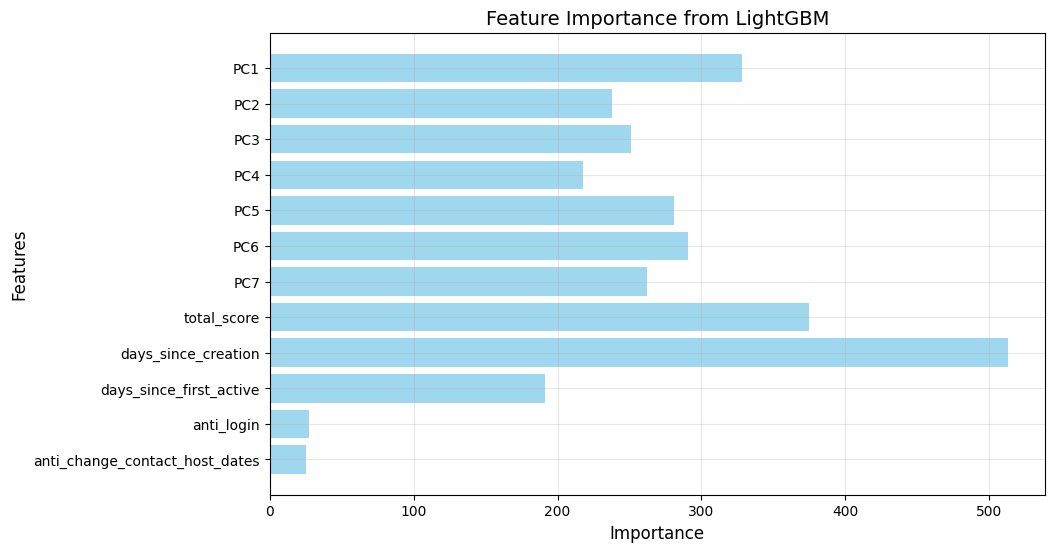

In [8]:
import matplotlib.pyplot as plt

# LightGBM 모델 학습 (다시 선언해서 필요할 경우 사용)
lightgbm_model = lgb.LGBMRegressor(random_state=42)
lightgbm_model.fit(X_train, y_train)

# 피처 중요도 가져오기
feature_importances = lightgbm_model.feature_importances_
features = X_train.columns  # X_train 컬럼 이름

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importances, color='skyblue', alpha=0.8)
plt.title('Feature Importance from LightGBM', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.gca().invert_yaxis()  # 중요도가 높은 순서로 정렬
plt.grid(alpha=0.3)
plt.show()


# 요기 아래로는 여러 테스트 현장으로 참고용으로 사용
## 위의 데이터 결과는 평균대비 MAE의 값이 높지만 값의 표준편차가 크기에 평균 +-범위내에 값을 예측한것으로 적당한 결과라 볼수있음 다만
## 어차피 "0일" 내 결제라는게 뻔한데 기간을 예측하는게 맞지 않아 우리는 "분류" 당일내 구매자와 당일내 구매하지 않는 자의 구분을 더 중요시 여거 회귀는 하이퍼파라미터 수정없이 넘어간다
## 분류를 통해 우리는 마케팅 및 사업부에서 필요할 당일내 구매자와 구매하지 않을자를 실시간 배치 데이터를 활용하여 학습한다음 구매 예정자에겐 보다 공격적인 마케팅을 진행할것을 제안하는 방향으로 간다


> - 스케일링 사용과, 사용하지 않은 버전:
> - anti-join 사용버전과, 사용하지 않은 버전

### 왜 참고용인가 ? A. 결과에 큰차이가 없기때문

In [12]:
# 스케일링 안한 버전
from sklearn.preprocessing import StandardScaler

log_pivot2 = log_pivot.drop(columns=['user_id'], errors='ignore')

from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pca_features = pca.fit_transform(log_pivot2)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance.cumsum()

print("Explained Variance Ratio:", explained_variance)
print("Cumulative Explained Variance:", cumulative_explained_variance)

for i in range(7):
    log_pivot[f'PC{i+1}'] = pca_features[:, i]

merged_data = pd.merge(main, log_pivot, left_on='id', right_on='user_id', how='left').fillna(0)
merged_data = pd.merge(merged_data, scores, left_on='id', right_on='user_id', how='left').fillna(0)


merged_data['date_account_created'] = pd.to_datetime(merged_data['date_account_created'])
merged_data['timestamp_first_active'] = pd.to_datetime(merged_data['timestamp_first_active'])
merged_data['days_since_creation'] = (merged_data['date_account_created'] - merged_data['date_account_created'].min()).dt.days
merged_data['days_since_first_active'] = (merged_data['timestamp_first_active'] - merged_data['timestamp_first_active'].min()).dt.days

merged_data = merged_data.drop(columns=['date_account_created', 'timestamp_first_active'], errors='ignore')


purchased_data = merged_data[merged_data['is_booked'] == 1].copy()


action_detail_to_user_ids = log.groupby('action_detail')['user_id'].apply(set).to_dict()


Explained Variance Ratio: [0.55878969 0.12597526 0.0767323  0.07130719 0.03921047 0.02300864
 0.01774222]
Cumulative Explained Variance: [0.55878969 0.68476494 0.76149725 0.83280444 0.87201491 0.89502355
 0.91276577]


In [13]:
for feature in anti_join_features:
    if feature in action_detail_to_user_ids:
        feature_user_ids = action_detail_to_user_ids[feature]
        purchased_data[f'anti_{feature}'] = purchased_data['id'].apply(lambda x: 1 if x in feature_user_ids else 0)
    else:
        purchased_data[f'anti_{feature}'] = 0


feature_columns = [
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
    'total_score', 'days_since_creation', 'days_since_first_active'
] + [f'anti_{feature}' for feature in anti_join_features]

X2 = purchased_data[feature_columns]
y2 = purchased_data['timedelta']

In [16]:
for feature in anti_join_features:
    if feature in action_detail_to_user_ids:
        feature_user_ids = action_detail_to_user_ids[feature]
        purchased_data[f'anti_{feature}'] = purchased_data['id'].apply(lambda x: 1 if x in feature_user_ids else 0)
    else:
        purchased_data[f'anti_{feature}'] = 0


feature_columns = [
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7',
    'total_score', 'days_since_creation', 'days_since_first_active'
]

X3 = purchased_data[feature_columns]
y3 = purchased_data['timedelta']

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")

Training Linear Regression...
Training Lasso Regression...
Training Ridge Regression...
Training ElasticNet...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Decision Tree...
Training K-Nearest Neighbors...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 38420, number of used features: 10
[LightGBM] [Info] Start training from score 52.812285
Linear Regression:
  Mean Absolute Error (MAE): 68.75
  Root Mean Squared Error (RMSE): 92.89
Lasso Regression:
  Mean Absolute Error (MAE): 68.77
  Root Mean Squared Error (RMSE): 92.89
Ridge Regression:
  Mean Absolute Error (MAE): 68.75
  Root Mean Squared Error (RMSE): 92.89
ElasticNet:
  Mean Absolut

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': xgb.XGBRegressor(random_state=42, eval_metric='rmse'),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results[model_name] = {'MAE': mae, 'RMSE': rmse}

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Mean Absolute Error (MAE): {metrics['MAE']:.2f}")
    print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.2f}")

Training Linear Regression...
Training Lasso Regression...
Training Ridge Regression...
Training ElasticNet...
Training Random Forest...
Training Gradient Boosting...
Training AdaBoost...
Training Decision Tree...
Training K-Nearest Neighbors...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2546
[LightGBM] [Info] Number of data points in the train set: 38420, number of used features: 12
[LightGBM] [Info] Start training from score 52.812285
Linear Regression:
  Mean Absolute Error (MAE): 68.54
  Root Mean Squared Error (RMSE): 92.82
Lasso Regression:
  Mean Absolute Error (MAE): 68.58
  Root Mean Squared Error (RMSE): 92.82
Ridge Regression:
  Mean Absolute Error (MAE): 68.54
  Root Mean Squared Error (RMSE): 92.82
ElasticNet:
  Mean Absolut

In [9]:
mean = merged_data['timedelta'].mean()
std = merged_data['timedelta'].std()

{mean, std}

{27.499311065710078, 73.17702004985091}

In [18]:
non_zero_mae = mean_absolute_error(y_test[y_test != 0], y_pred[y_test != 0])
print(non_zero_mae)

72.60739476590662


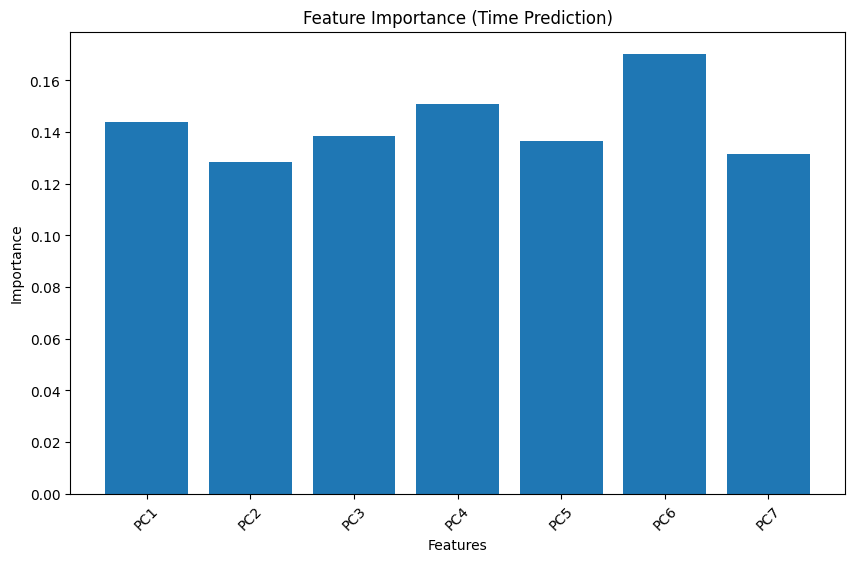

In [12]:
import matplotlib.pyplot as plt

# Feature 중요도
feature_importances = regressor.feature_importances_
features = X.columns

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(features, feature_importances)
plt.title("Feature Importance (Time Prediction)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


In [14]:
# 주요 행동 도출
important_actions = log[log['user_id'].isin(purchased_data['id'])]['action_detail'].value_counts().head(10)
print("Top Actions for Purchasers:\n", important_actions)


Top Actions for Purchasers:
 action_detail
view_search_results            250006
-unknown-                      180771
unknown                        178839
p3                             165368
wishlist_content_update        132848
change_trip_characteristics     97555
similar_listings                92714
user_profile                    66898
update_listing                  32222
message_thread                  31799
Name: count, dtype: int64
